Loading features from: /groups/pheno/inar/icecube_kaggle/train/batch_1.parquet
Loading metadata from: /groups/pheno/inar/icecube_kaggle/train_meta.parquet
Sampling 1000 events...
Using 138742 pulses from 1000 events.

Analyzing 'time' feature...
Time Min: 5729, Max: 46018
Time Mean: 12460.06, Median: 11904.00, Std: 3290.58


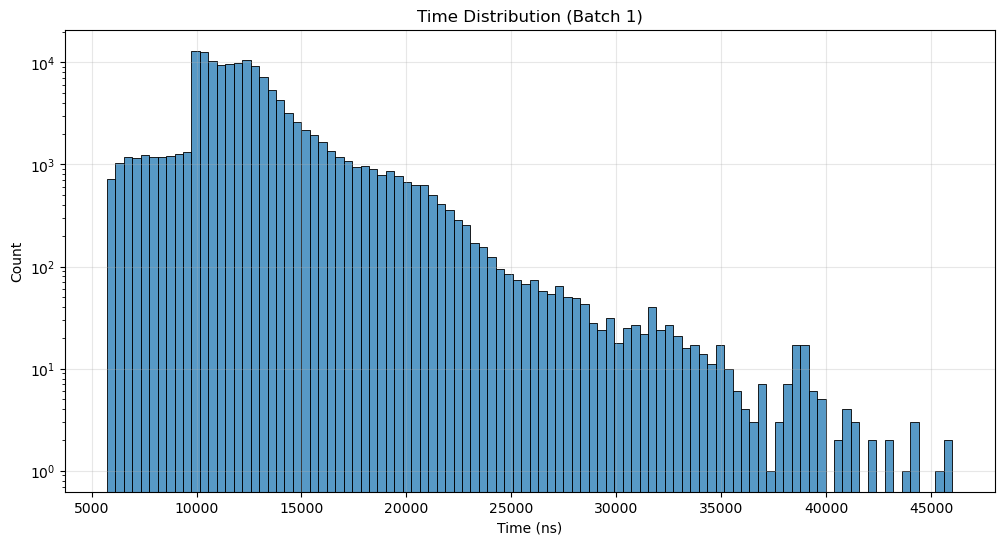


Analyzing 'charge' feature...
Charge Min: 0.0250, Max: 462.12
Charge Mean: 2.28, Median: 1.02, Std: 8.81
Charge <= 0 count: 0


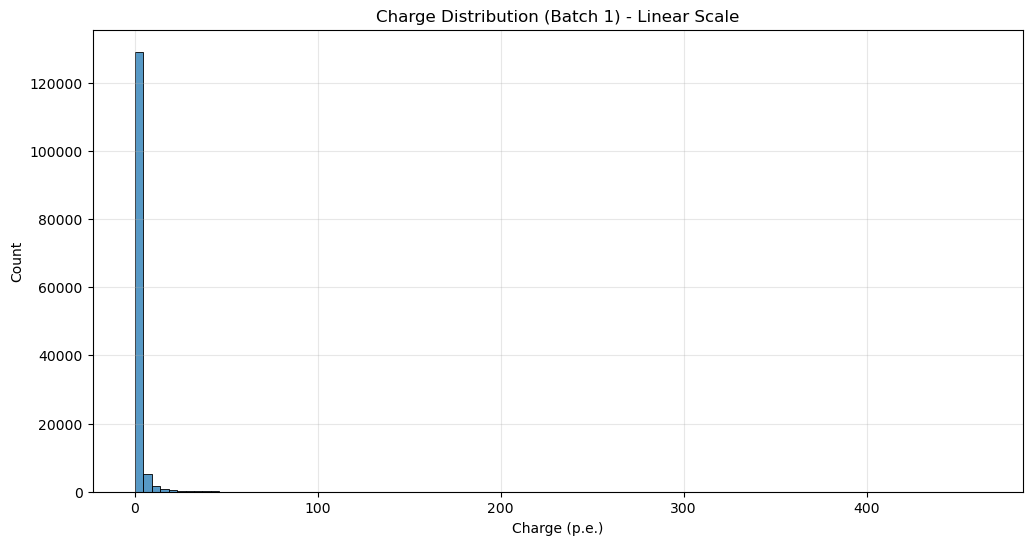

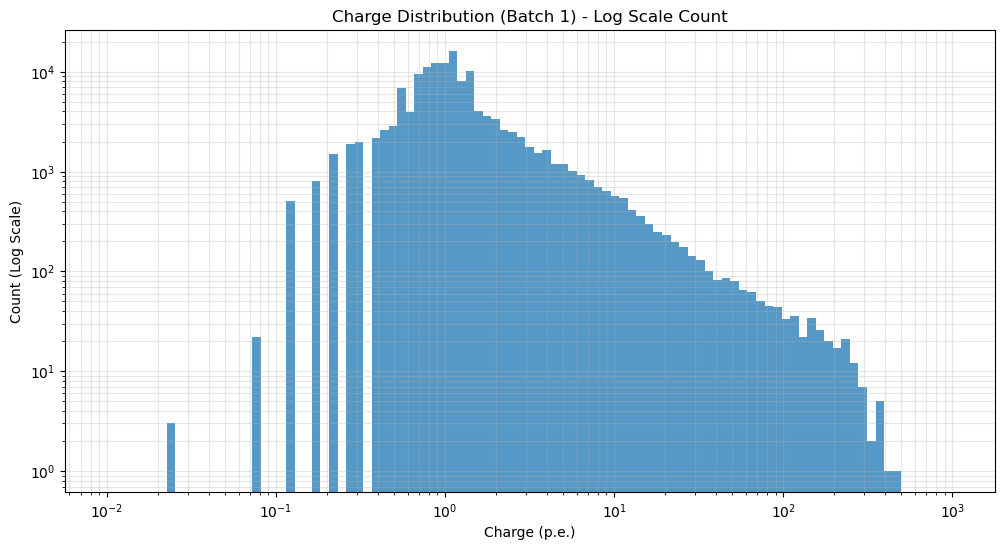

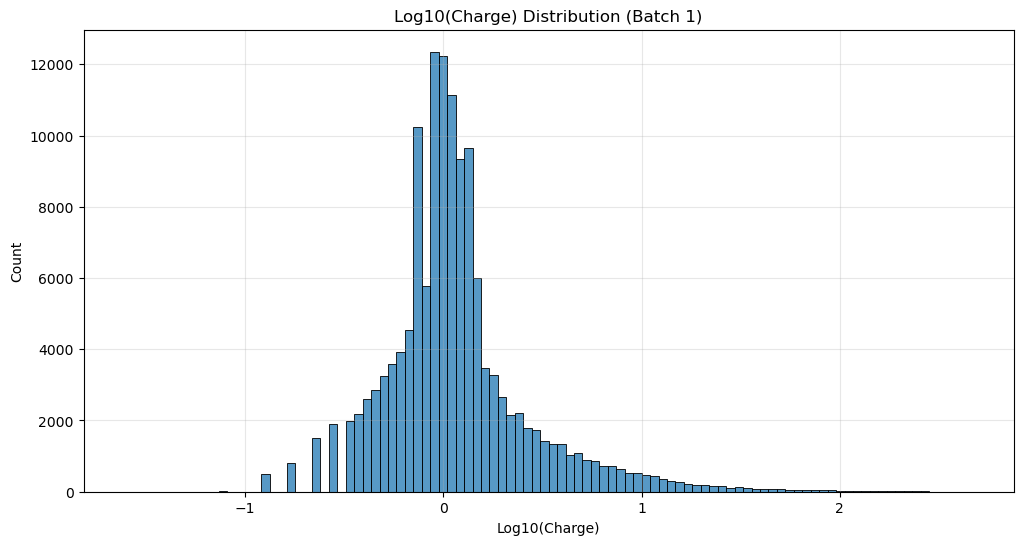

In [4]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm # Use notebook version for better display

# --- Configuration ---
KAGGLE_TRAIN_PATH = '/groups/pheno/inar/icecube_kaggle/train'
BATCH_ID_TO_LOAD = 1 # Choose a batch file to analyze
N_EVENTS_TO_SAMPLE = 1000 # Optional: Load only a sample of events for quicker analysis, set to None to load all
OUTPUT_DIR = './data_analysis_plots'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Load Data ---
batch_file = os.path.join(KAGGLE_TRAIN_PATH, f'batch_{BATCH_ID_TO_LOAD}.parquet')
meta_file = '/groups/pheno/inar/icecube_kaggle/train_meta.parquet' # Path to your meta file

print(f"Loading features from: {batch_file}")
features_df = pd.read_parquet(batch_file)

print(f"Loading metadata from: {meta_file}")
meta_df = pd.read_parquet(meta_file)
# Filter metadata for the specific batch if needed
batch_meta_df = meta_df[meta_df['batch_id'] == BATCH_ID_TO_LOAD]

# --- Optional Sampling ---
if N_EVENTS_TO_SAMPLE is not None:
    print(f"Sampling {N_EVENTS_TO_SAMPLE} events...")
    event_ids_in_batch = batch_meta_df['event_id'].unique()
    sampled_event_ids = np.random.choice(event_ids_in_batch, N_EVENTS_TO_SAMPLE, replace=False)
    
    # Filter features based on sampled event IDs
    # Ensure the index is named 'event_id' or reset it
    if features_df.index.name != 'event_id':
         print("Warning: Index name is not 'event_id'. Trying to reset index.")
         # If event_id is a column:
         # features_df = features_df.set_index('event_id')
         # If it's the default index and event_id is NOT a column (less likely for parquet):
         # This case is tricky, ensure your parquet writing preserves event_id correctly.
         # For now, assuming event_id is the index:
         pass # If it's already the index.

    features_df = features_df[features_df.index.isin(sampled_event_ids)]
    print(f"Using {len(features_df)} pulses from {len(sampled_event_ids)} events.")


# --- Analyze Time ---
print("\nAnalyzing 'time' feature...")
time_data = features_df['time'].to_numpy()

print(f"Time Min: {time_data.min()}, Max: {time_data.max()}")
print(f"Time Mean: {time_data.mean():.2f}, Median: {np.median(time_data):.2f}, Std: {time_data.std():.2f}")

# Plot Time Distribution
plt.figure(figsize=(12, 6))
sns.histplot(time_data, bins=100, kde=False)
plt.title(f'Time Distribution (Batch {BATCH_ID_TO_LOAD})')
plt.xlabel('Time (ns)')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.yscale('log')
# plt.savefig(os.path.join(OUTPUT_DIR, f'time_distribution_batch_{BATCH_ID_TO_LOAD}.png'))
plt.show()

# --- Analyze Charge ---
print("\nAnalyzing 'charge' feature...")
charge_data = features_df['charge'].to_numpy()

print(f"Charge Min: {charge_data.min():.4f}, Max: {charge_data.max():.2f}")
print(f"Charge Mean: {charge_data.mean():.2f}, Median: {np.median(charge_data):.2f}, Std: {charge_data.std():.2f}")
print(f"Charge <= 0 count: {np.sum(charge_data <= 0)}") # Check for non-positive values if using log

# Plot Charge Distribution (Linear Scale)
plt.figure(figsize=(12, 6))
sns.histplot(charge_data, bins=100, kde=False)
plt.title(f'Charge Distribution (Batch {BATCH_ID_TO_LOAD}) - Linear Scale')
plt.xlabel('Charge (p.e.)')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
# plt.savefig(os.path.join(OUTPUT_DIR, f'charge_distribution_linear_batch_{BATCH_ID_TO_LOAD}.png'))
plt.show()

# Plot Charge Distribution (Log Scale for Y axis)
plt.figure(figsize=(12, 6))
sns.histplot(charge_data, bins=np.logspace(-2,3, 100), kde=False)
plt.xscale('log')
plt.yscale('log')
plt.title(f'Charge Distribution (Batch {BATCH_ID_TO_LOAD}) - Log Scale Count')
plt.xlabel('Charge (p.e.)')
plt.ylabel('Count (Log Scale)')
plt.grid(True, which='both', alpha=0.3)
# plt.savefig(os.path.join(OUTPUT_DIR, f'charge_distribution_logy_batch_{BATCH_ID_TO_LOAD}.png'))
plt.show()

# Plot Charge Distribution (Log Scale for X axis - handle non-positive values)
plt.figure(figsize=(12, 6))
charge_positive = charge_data[charge_data > 0]
if len(charge_positive) > 0:
    sns.histplot(np.log10(charge_positive), bins=100, kde=False)
    plt.title(f'Log10(Charge) Distribution (Batch {BATCH_ID_TO_LOAD})')
    plt.xlabel('Log10(Charge)')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)
    # plt.savefig(os.path.join(OUTPUT_DIR, f'charge_distribution_logx_batch_{BATCH_ID_TO_LOAD}.png'))
    plt.show()
else:
    print("No positive charge values found for log10 plot.")



In [ ]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import os
from tqdm import tqdm
import glob # To easily list files

# --- Configuration ---
KAGGLE_TRAIN_PATH = '/groups/pheno/inar/icecube_kaggle/train'
NUM_BATCHES_TO_CHECK = 20

# --- Find Parquet Files ---
# Use glob to find the first N batch files matching the pattern
batch_files = sorted(glob.glob(os.path.join(KAGGLE_TRAIN_PATH, 'batch_*.parquet')))
files_to_load = batch_files[:NUM_BATCHES_TO_CHECK]

if not files_to_load:
    print(f"Error: No batch files found in {KAGGLE_TRAIN_PATH}")
else:
    print(f"Found {len(batch_files)} batch files. Checking the first {len(files_to_load)}:")
    #for f in files_to_load:
    #    print(f" - {os.path.basename(f)}") # Optional: print file names

    # --- Load Time and Find Max ---
    overall_max_time = -1
    all_times = [] # Optional: Collect all times if you want a combined histogram

    print("\nLoading 'time' column from batch files...")
    for batch_file in tqdm(files_to_load):
        try:
            # Read only the 'time' column for efficiency
            features_df = pd.read_parquet(batch_file, columns=['time'])
            batch_max_time = features_df['time'].max()
            #all_times.append(features_df['time'].to_numpy()) # Optional

            if batch_max_time > overall_max_time:
                overall_max_time = batch_max_time
                print(f"New max time found: {overall_max_time} (in {os.path.basename(batch_file)})")

        except Exception as e:
            print(f"Error processing file {batch_file}: {e}")

    print(f"\nFinished checking {len(files_to_load)} files.")
    print(f"Overall Maximum Time Found: {overall_max_time}")

    # --- Optional: Plot combined distribution ---
    # if all_times:
    #    combined_times = np.concatenate(all_times)
    #    plt.figure(figsize=(12, 6))
    #    sns.histplot(combined_times, bins=200, kde=False) # More bins might be needed
    #    plt.yscale('log')
    #    plt.title(f'Combined Time Distribution (First {len(files_to_load)} Batches)')
    #    plt.xlabel('Time (ns)')
    #    plt.ylabel('Count (Log Scale)')
    #    plt.grid(True, which='both', alpha=0.3)
    #    # plt.savefig(os.path.join(OUTPUT_DIR, f'time_distribution_combined_{len(files_to_load)}_batches.png'))
    #    plt.show()

    # --- Decision on Clipping/Vocab Size ---
    MAX_TIME_VOCAB = 65000
    print(f"\nProposed clipping value: {MAX_TIME_VOCAB}")
    if overall_max_time > MAX_TIME_VOCAB:
        print(f"The overall max time ({overall_max_time}) exceeds the proposed clipping value.")
        # Calculate approx range after inversion and clipping
        # Note: This uses the max value found, actual max after inversion might differ slightly due to rounding
        time_int_max_clipped = np.clip(np.round(overall_max_time).astype(int), 0, MAX_TIME_VOCAB)
        time_vocab_size = MAX_TIME_VOCAB + 1 # +1 for zero-based index
        print(f"Effective max integer time after clipping: {time_int_max_clipped}")

    else:
        # If max time is already below clip value, clip value isn't strictly necessary
        # but can still be used to set a fixed vocab size.
        time_int_max = np.round(overall_max_time).astype(int)
        time_vocab_size = MAX_TIME_VOCAB + 1 # Or potentially time_int_max + 1 if you don't clip
        print(f"Overall max time ({overall_max_time}) is within the proposed clipping range.")
        print(f"Effective max integer time: {time_int_max}")

    print(f"Using clipping at {MAX_TIME_VOCAB}, the required Time Embedding Vocab Size: {time_vocab_size}")

Found 660 batch files. Checking the first 20:

Loading 'time' column from batch files...


New max time found: 77785 (in batch_1.parquet)
New max time found: 85317 (in batch_10.parquet)


New max time found: 99242 (in batch_102.parquet)


New max time found: 116225 (in batch_104.parquet)


New max time found: 121768 (in batch_114.parquet)


100%|██████████| 20/20 [00:04<00:00,  4.92it/s]


Finished checking 20 files.
Overall Maximum Time Found: 121768

Proposed clipping value: 65000
The overall max time (121768) exceeds the proposed clipping value.
Effective max integer time after clipping: 65000
Using clipping at 65000, the required Time Embedding Vocab Size: 65001


Loading features from: /groups/pheno/inar/icecube_kaggle/train/batch_114.parquet
Loading metadata from: /groups/pheno/inar/icecube_kaggle/train_meta.parquet
Loading sensor geometry from: /groups/pheno/inar/icecube_kaggle/sensor_geometry.csv

Finding pulses with time > 60000...
Found 9 events containing pulses with time > 60000.
Selected events to plot: [np.int64(368936521), np.int64(369617120), np.int64(368915096), np.int64(369385111), np.int64(369430979)]

Generating plots for 5 events...
  Processing event 368936521...


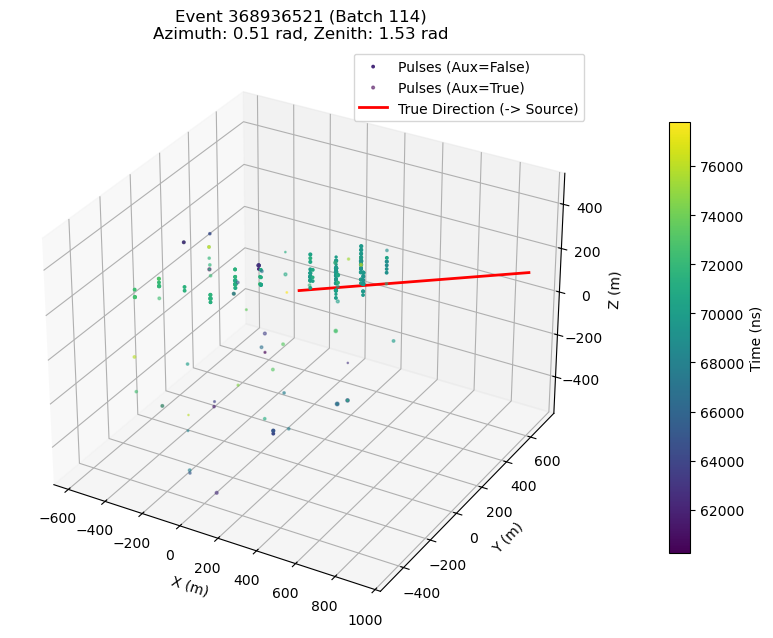

  Processing event 369617120...


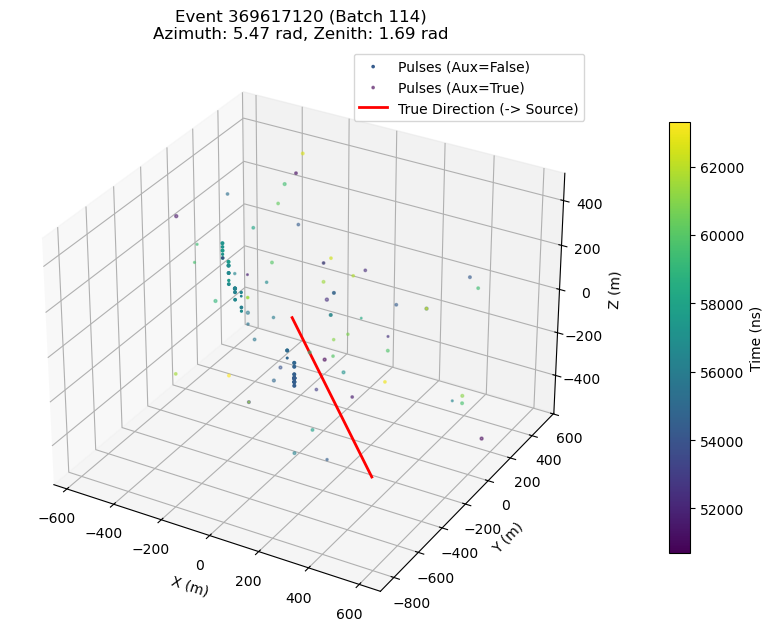

  Processing event 368915096...


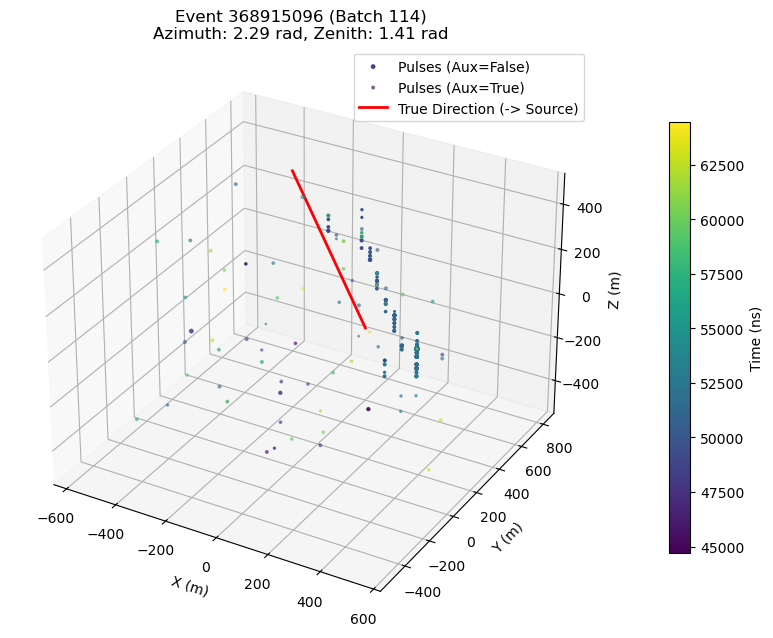

  Processing event 369385111...


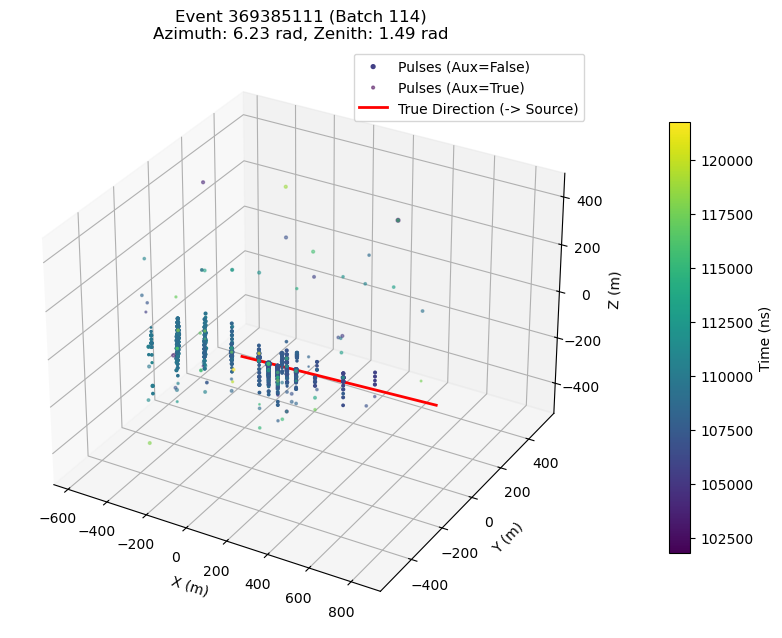

  Processing event 369430979...


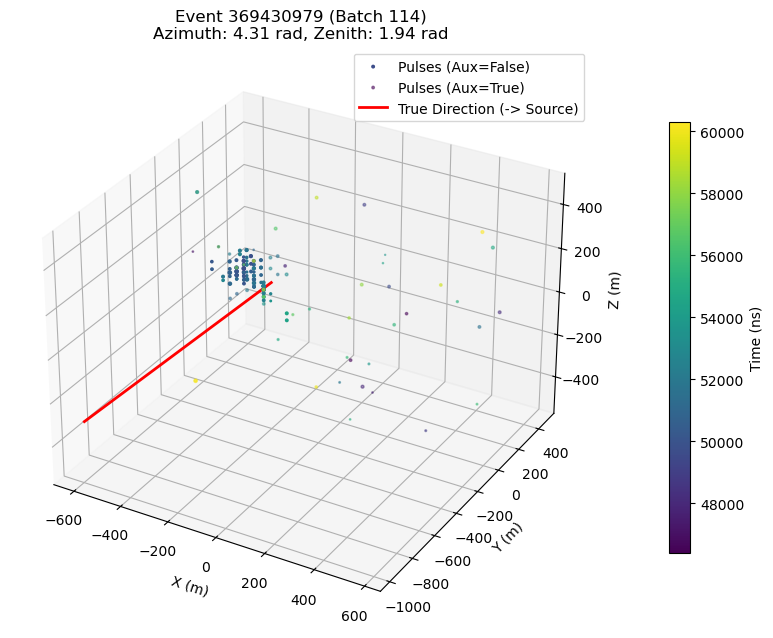


Finished plotting selected events.


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Import for 3D plotting
import os
# from tqdm.notebook import tqdm # Removed

# --- Configuration ---
KAGGLE_DATA_PATH = '/groups/pheno/inar/icecube_kaggle/' # Base path to Kaggle data
BATCH_ID_TO_LOAD = 114
TIME_THRESHOLD = 60000 # Look for pulses with time greater than this
NUM_EVENTS_TO_PLOT = 5 # How many example events to visualize
MARKER_SIZE_SCALE = 5 # Adjust this to scale marker size appropriately
DIRECTION_LINE_LENGTH = 1000 # Length of the direction vector line in meters
# !!! IMPORTANT: Update this path to your sensor geometry file !!!
SENSOR_GEOMETRY_PATH = os.path.join(KAGGLE_DATA_PATH, 'sensor_geometry.csv') # Or appropriate path

# --- Load Data ---
batch_file = os.path.join(KAGGLE_DATA_PATH, 'train', f'batch_{BATCH_ID_TO_LOAD}.parquet')
meta_file = os.path.join(KAGGLE_DATA_PATH, 'train_meta.parquet')

print(f"Loading features from: {batch_file}")
features_df = pd.read_parquet(batch_file)

print(f"Loading metadata from: {meta_file}")
meta_df = pd.read_parquet(meta_file)
# Filter metadata for the specific batch and set event_id as index for easy lookup
batch_meta_df = meta_df[meta_df['batch_id'] == BATCH_ID_TO_LOAD].set_index('event_id')

# --- Load Sensor Geometry ---
print(f"Loading sensor geometry from: {SENSOR_GEOMETRY_PATH}")
if not os.path.exists(SENSOR_GEOMETRY_PATH):
    print(f"Error: Sensor geometry file not found at {SENSOR_GEOMETRY_PATH}")
    # Create dummy data as a placeholder:
    print("Creating dummy sensor geometry as placeholder...")
    all_sensor_ids = features_df['sensor_id'].unique()
    sensor_geometry_df = pd.DataFrame({
        'sensor_id': all_sensor_ids,
        'x': np.random.uniform(-500, 500, size=len(all_sensor_ids)),
        'y': np.random.uniform(-500, 500, size=len(all_sensor_ids)),
        'z': np.random.uniform(-500, 500, size=len(all_sensor_ids))
    })
    print("WARNING: Using dummy sensor geometry. Plots will not be physically accurate.")
else:
    sensor_geometry_df = pd.read_csv(SENSOR_GEOMETRY_PATH)
    # Optional: Ensure sensor_id column has the correct type if needed
    # sensor_geometry_df['sensor_id'] = sensor_geometry_df['sensor_id'].astype(int)


# --- Identify Events with Large Timestamps ---
print(f"\nFinding pulses with time > {TIME_THRESHOLD}...")
large_time_pulses = features_df[features_df['time'] > TIME_THRESHOLD]

if large_time_pulses.empty:
    print(f"No pulses found with time > {TIME_THRESHOLD} in batch {BATCH_ID_TO_LOAD}.")
    events_to_plot = [] # Ensure this list exists but is empty
else:
    # Ensure index is 'event_id' or reset if necessary for feature DataFrame
    if features_df.index.name != 'event_id':
         print("Setting index to 'event_id' for feature DataFrame...")
         try:
            if 'event_id' in features_df.columns:
                 features_df = features_df.set_index('event_id')
            else:
                 features_df.index.name = 'event_id'
         except KeyError:
             print("Error: 'event_id' column not found or index couldn't be set.")
             exit() # Or set events_to_plot = []

    events_with_large_times = large_time_pulses.index.unique()
    print(f"Found {len(events_with_large_times)} events containing pulses with time > {TIME_THRESHOLD}.")

    # Select events to plot
    events_to_plot = np.random.choice(
        events_with_large_times,
        min(NUM_EVENTS_TO_PLOT, len(events_with_large_times)),
        replace=False
    )
    print(f"Selected events to plot: {list(events_to_plot)}")


# --- Generate Plots ---
print(f"\nGenerating plots for {len(events_to_plot)} events...")
for event_id in events_to_plot:
    print(f"  Processing event {event_id}...")
    # Get all pulses for the current event
    try:
        event_features = features_df.loc[[event_id]].reset_index() # Get event_id as column
    except KeyError:
        print(f"    Error: Could not locate event {event_id} in features DataFrame. Skipping.")
        continue

    # Get metadata for the event
    has_metadata = False
    try:
        event_meta = batch_meta_df.loc[event_id]
        azimuth = event_meta['azimuth']
        zenith = event_meta['zenith']
        title = f"Event {event_id} (Batch {BATCH_ID_TO_LOAD})\nAzimuth: {azimuth:.2f} rad, Zenith: {zenith:.2f} rad"
        has_metadata = True # Flag that we have angles
    except KeyError:
        print(f"    Warning: Metadata not found for event {event_id}. Plotting without angles or direction line.")
        title = f"Event {event_id} (Batch {BATCH_ID_TO_LOAD}) - Metadata Missing"
        azimuth = None
        zenith = None


    # Merge features with sensor geometry
    event_data_plot = pd.merge(
        event_features,
        sensor_geometry_df,
        on='sensor_id',
        how='left' # Keep all pulses even if sensor geometry is missing
    )

    # Check for missing geometry data
    missing_geo = event_data_plot['x'].isnull().sum()
    if missing_geo > 0:
        print(f"    Warning: Event {event_id} has {missing_geo} pulses with missing sensor geometry data. These won't be plotted.")
        event_data_plot.dropna(subset=['x', 'y', 'z'], inplace=True)

    if event_data_plot.empty:
         print(f"    Skipping event {event_id} - no plottable data after geometry merge.")
         continue

    # --- Create Matplotlib Figure ---
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # --- Split data based on 'auxiliary' ---
    non_aux_data = event_data_plot[~event_data_plot['auxiliary']].copy()
    aux_data = event_data_plot[event_data_plot['auxiliary']].copy()

    # Determine consistent color limits based on the *full* event's time range
    vmin = event_data_plot['time'].min()
    vmax = event_data_plot['time'].max()

    # --- Plot Non-Auxiliary Pulses (alpha 1.0) ---
    if not non_aux_data.empty:
        sc1 = ax.scatter(
            non_aux_data['x'], non_aux_data['y'], non_aux_data['z'],
            c=non_aux_data['time'],
            s=np.log1p(non_aux_data['charge']) * MARKER_SIZE_SCALE,
            cmap='viridis',
            alpha=1.0,
            label='Pulses (Aux=False)',
            vmin=vmin, vmax=vmax
        )

    # --- Plot Auxiliary Pulses (alpha 0.5) ---
    if not aux_data.empty:
        sc2 = ax.scatter(
            aux_data['x'], aux_data['y'], aux_data['z'],
            c=aux_data['time'],
            s=np.log1p(aux_data['charge']) * MARKER_SIZE_SCALE,
            cmap='viridis',
            alpha=0.5,
            label='Pulses (Aux=True)',
            vmin=vmin, vmax=vmax
        )

    # --- Add Direction Line (if metadata exists) ---
    if has_metadata:
        # Calculate center of pulses as origin for the line
        center_x = event_data_plot['x'].mean()
        center_y = event_data_plot['y'].mean()
        center_z = event_data_plot['z'].mean()

        # Calculate direction vector components (points *towards* source)
        vx = np.sin(zenith) * np.cos(azimuth)
        vy = np.sin(zenith) * np.sin(azimuth)
        vz = np.cos(zenith)

        # Calculate line endpoints
        line_start = np.array([center_x, center_y, center_z])
        line_end = line_start + DIRECTION_LINE_LENGTH * np.array([vx, vy, vz])

        # Plot the line
        ax.plot(
            [line_start[0], line_end[0]],
            [line_start[1], line_end[1]],
            [line_start[2], line_end[2]],
            color='red',
            linewidth=2,
            label='True Direction (-> Source)'
        )

    # --- Add Colorbar ---
    # Choose which scatter plot to attach the colorbar to
    scatter_obj_for_colorbar = None
    if not non_aux_data.empty:
      scatter_obj_for_colorbar = sc1
    elif not aux_data.empty:
      scatter_obj_for_colorbar = sc2

    if scatter_obj_for_colorbar:
        cbar = fig.colorbar(scatter_obj_for_colorbar, ax=ax, label='Time (ns)', pad=0.1, shrink=0.7)

    # --- Add Labels, Title, Legend ---
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title(title)
    ax.legend()

    # --- Adjust Aspect Ratio ---
    # ax.set_box_aspect([np.ptp(event_data_plot['x']), np.ptp(event_data_plot['y']), np.ptp(event_data_plot['z'])])

    plt.show()

    # Optional: Save plot
    # plot_output_dir = './event_plots_mpl_dir'
    # os.makedirs(plot_output_dir, exist_ok=True)
    # fig.savefig(os.path.join(plot_output_dir, f'event_{event_id}_batch_{BATCH_ID_TO_LOAD}_dir_mpl.png'), dpi=150, bbox_inches='tight')
    # plt.close(fig)

print("\nFinished plotting selected events.")

We see that there are events with all pulses pretty late.

The data description says:
time (int): the time of the pulse in nanoseconds in the current event time window. The absolute time of a pulse has no relevance, and only the relative time with respect to other pulses within an event is of relevance.

So maybe we can always subtract the time of the first pulse. It is a bit tricky since there is also dark noise and cosmic muons in those events. 

See the discussion here https://www.kaggle.com/competitions/icecube-neutrinos-in-deep-ice/discussion/402882


In [25]:
import pandas as pd
import numpy as np
import os
import glob
from tqdm import tqdm # Use notebook tqdm again

# --- Configuration ---
KAGGLE_DATA_PATH = '/groups/pheno/inar/icecube_kaggle/' # Base path to Kaggle data
NUM_BATCHES_TO_CHECK = 20

# --- Find Parquet Files ---
print(f"Finding batch files in {os.path.join(KAGGLE_DATA_PATH, 'train')}...")
batch_files = sorted(glob.glob(os.path.join(KAGGLE_DATA_PATH, 'train', 'batch_*.parquet')))
files_to_load = batch_files[:NUM_BATCHES_TO_CHECK]

if not files_to_load:
    print(f"Error: No batch files found in {os.path.join(KAGGLE_DATA_PATH, 'train')}")
else:
    print(f"Found {len(batch_files)} batch files. Processing the first {len(files_to_load)}...")

    overall_max_relative_time = -1
    events_processed_count = 0

    # --- Process Batches ---
    for batch_file in tqdm(files_to_load, desc="Processing Batches"):
        batch_num = os.path.basename(batch_file).split('_')[-1].split('.')[0]
        # print(f"Processing {os.path.basename(batch_file)}...") # Optional: print file name
        try:
            # Load features for the current batch
            # No need for metadata or geometry for this analysis
            features_df = pd.read_parquet(batch_file, columns=['time']) # Only load time

            # Ensure event_id is available (usually index, might need reset)
            if features_df.index.name != 'event_id':
                 if 'event_id' in features_df.columns:
                     features_df = features_df.set_index('event_id')
                 else:
                     print(f"Warning: Could not identify event_id index/column in {batch_file}. Skipping this batch.")
                     continue # Skip to next file

            if features_df.empty:
                print(f"Warning: {batch_file} is empty or has no time data. Skipping.")
                continue

            # Calculate relative time within each event
            # time - t_min for each event
            features_df['time_relative'] = features_df.groupby(level='event_id')['time'] \
                                                      .transform(lambda x: x - x.min())

            # Find the maximum relative time in this batch
            batch_max_relative_time = features_df['time_relative'].max()
            events_processed_count += features_df.index.nunique()


            # Update overall maximum if necessary
            if batch_max_relative_time > overall_max_relative_time:
                overall_max_relative_time = batch_max_relative_time
                print(f"  > New max relative time found: {overall_max_relative_time:.0f} ns (in Batch {batch_num})")


        except Exception as e:
            print(f"Error processing file {batch_file}: {e}")

    # --- Report Results ---
    print("\n--------------------------------------------------")
    print(f"Finished processing {len(files_to_load)} batch files.")
    print(f"Total events analyzed: {events_processed_count}")
    if overall_max_relative_time > -1:
        print(f"Overall Maximum Relative Time (t - t_min): {overall_max_relative_time:.0f} ns")

        # Discuss implications for time embedding vocab size
        proposed_clip_val = 65000 # Your earlier proposal based on absolute time
        if overall_max_relative_time < proposed_clip_val:
            print(f"\nRecommendation: The max relative time ({overall_max_relative_time:.0f} ns) ")
            print(f"is less than the previous proposal of {proposed_clip_val} ns based on absolute time.")
            # Suggest clipping based on relative time + a buffer
            new_clip_val = int(np.ceil(overall_max_relative_time / 1000.0)) * 1000 + 1000 # Round up to nearest 1000 + buffer
            print(f"Consider clipping relative time at ~{new_clip_val} ns for the embedding.")
            print(f"This would require a time embedding vocabulary size of approx. {new_clip_val + 1}.")
        else:
            print(f"\nNote: The max relative time ({overall_max_relative_time:.0f} ns) ")
            print(f"still exceeds the proposed clipping value of {proposed_clip_val} ns.")
            print("Clipping at 65000 ns might still be reasonable, but will cut off the tails of some long events.")
            print(f"Using {proposed_clip_val + 1} as vocab size seems viable.")

    else:
        print("No valid relative time data found.")
    print("--------------------------------------------------")

Finding batch files in /groups/pheno/inar/icecube_kaggle/train...
Found 660 batch files. Processing the first 20...


  > New max relative time found: 36758 ns (in Batch 1)


  > New max relative time found: 48027 ns (in Batch 10)


  > New max relative time found: 48833 ns (in Batch 110)


  > New max relative time found: 49010 ns (in Batch 115)


Processing Batches: 100%|██████████| 20/20 [05:23<00:00, 16.20s/it]


--------------------------------------------------
Finished processing 20 batch files.
Total events analyzed: 4000000
Overall Maximum Relative Time (t - t_min): 49010 ns

Recommendation: The max relative time (49010 ns) 
is less than the previous proposal of 65000 ns based on absolute time.
Consider clipping relative time at ~51000 ns for the embedding.
This would require a time embedding vocabulary size of approx. 51001.
--------------------------------------------------
